In [4]:
# 1) Imports & setup
import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay)

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 120)

print("Python:", sys.version)


Python: 3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [5]:
# 2) Load data & quick sanity checks
CSV_PATH = "diabetic_data.csv"   # change if your filename is different
assert os.path.exists(CSV_PATH), f"File not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head(3)


Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [6]:
# 3) Target recode -> y in {0,1}
# Typical values are '<30', '>30', 'NO' (sometimes with whitespace)
df['readmitted'] = df['readmitted'].astype(str).str.strip()
df = df[df['readmitted'].isin(['<30', '>30', 'NO'])].copy()

df['y'] = (df['readmitted'] == '<30').astype(int)
print(df['readmitted'].value_counts(dropna=False))
print("y counts:", np.bincount(df['y']))


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64
y counts: [90409 11357]


In [7]:
# 4) Feature sets (numeric & categorical) — robust version

import numpy as np
import pandas as pd

# --- ensure target y exists; create from 'readmitted' if needed ---
if 'y' not in df.columns:
    if 'readmitted' not in df.columns:
        raise KeyError("Neither 'y' nor 'readmitted' found in df. Load the dataset first.")
    df['readmitted'] = df['readmitted'].astype(str).str.strip()
    # keep only valid labels
    df = df[df['readmitted'].isin(['<30','>30','NO'])].copy()
    df['y'] = (df['readmitted'] == '<30').astype(int)

# --- make a case-insensitive resolver for column names ---
df_cols_lower = {c.lower(): c for c in df.columns}  # map lower->original

def resolve(cols_requested):
    """Return list of actual df column names matching requested (case-insensitive)."""
    found, missing = [], []
    for c in cols_requested:
        c_low = c.lower()
        if c_low in df_cols_lower:
            found.append(df_cols_lower[c_low])
        else:
            missing.append(c)
    return found, missing

# requested features (as in the UCI dataset)
num_cols_req = [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient'
]
cat_cols_req = [
    'age','gender','race','admission_type_id','discharge_disposition_id','admission_source_id'
]

# resolve against actual df columns (case-insensitive)
present_num, missing_num = resolve(num_cols_req)
present_cat, missing_cat = resolve(cat_cols_req)

missing = sorted(set(missing_num + missing_cat))
if missing:
    print("Warning: missing columns ignored ->", missing)

# --- build X and y ---
use_cols = present_num + present_cat
if not use_cols:
    raise ValueError("No requested features found in the dataset. Check column names with list(df.columns).")

X = df[use_cols].copy()
y = df['y'].astype(int).values

# --- coerce numeric columns & clean categoricals ---
# numeric: to numeric (errors->NaN; will be imputed later in pipeline)
for c in present_num:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# categoricals: ensure strings without leading/trailing whitespace
for c in present_cat:
    X[c] = X[c].astype(str).str.strip()

# --- quick diagnostics ---
print("X shape:", X.shape, "| y shape:", y.shape)
print("Numeric features present:", present_num)
print("Categorical features present:", present_cat)
# show class balance
print("y class counts:", pd.Series(y).value_counts().to_dict())

# peek at data
display(X.head())


X shape: (101766, 13) | y shape: (101766,)
Numeric features present: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
Categorical features present: ['age', 'gender', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
y class counts: {0: 90409, 1: 11357}


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,age,gender,race,admission_type_id,discharge_disposition_id,admission_source_id
0,1,41,0,1,0,0,0,[0-10),Female,Caucasian,6,25,1
1,3,59,0,18,0,0,0,[10-20),Female,Caucasian,1,1,7
2,2,11,5,13,2,0,1,[20-30),Female,AfricanAmerican,1,1,7
3,2,44,1,16,0,0,0,[30-40),Male,Caucasian,1,1,7
4,1,51,0,8,0,0,0,[40-50),Male,Caucasian,1,1,7


In [8]:
# 5) Train/test split (stratified when safe)
test_size = 0.30
# Need at least 2 samples of each class in the test fold
min_needed = int(np.ceil(2/test_size))
vc = pd.Series(y).value_counts()
can_stratify = vc.min() >= min_needed
print("Can stratify:", bool(can_stratify), "Class counts:", vc.to_dict())

split_kwargs = dict(test_size=test_size, random_state=42)
if can_stratify:
    split_kwargs['stratify'] = y

X_train, X_test, y_train, y_test = train_test_split(X, y, **split_kwargs)
X_train.shape, X_test.shape


Can stratify: True Class counts: {0: 90409, 1: 11357}


((71236, 13), (30530, 13))

In [9]:
# 6) Robust preprocessing and Logistic Regression
import sklearn
ohe_kwargs = {'handle_unknown': 'ignore'}
major, minor = [int(x) for x in sklearn.__version__.split('.')[:2]]
# Use sparse to reduce memory pressure with many dummies
if (major, minor) >= (1, 2):
    ohe_kwargs['sparse_output'] = True
else:
    ohe_kwargs['sparse'] = True

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(**ohe_kwargs))
])

pre = ColumnTransformer([
    ('num', num_pipe, present_num),
    ('cat', cat_pipe, present_cat)
], remainder='drop')

clf = Pipeline([
    ('pre', pre),
    ('lr', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced'
    ))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Accuracy :", round(accuracy_score(y_test, pred), 4))
print("Precision:", round(precision_score(y_test, pred), 4))
print("Recall   :", round(recall_score(y_test, pred), 4))
print("AUC      :", round(roc_auc_score(y_test, proba), 4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))


Accuracy : 0.6806
Precision: 0.1835
Recall   : 0.5398
AUC      : 0.6676
Confusion matrix:
 [[18941  8182]
 [ 1568  1839]]
              precision    recall  f1-score   support

           0      0.924     0.698     0.795     27123
           1      0.184     0.540     0.274      3407

    accuracy                          0.681     30530
   macro avg      0.554     0.619     0.535     30530
weighted avg      0.841     0.681     0.737     30530



<Figure size 600x400 with 0 Axes>

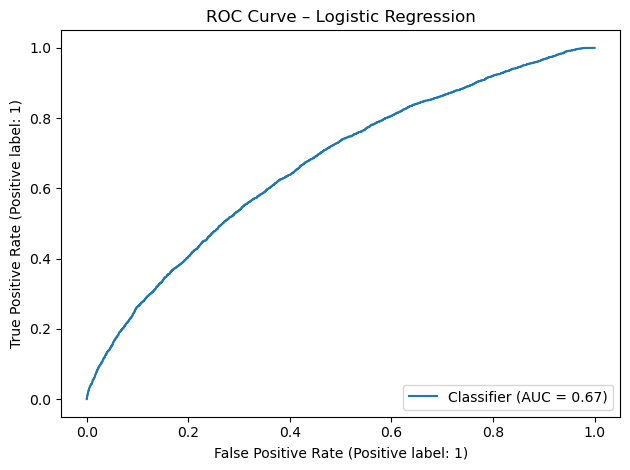

In [10]:
# 7) ROC curve (matplotlib)
plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve – Logistic Regression")
plt.tight_layout()
os.makedirs("results", exist_ok=True)
plt.savefig("results/fig_roc_logistic.png", dpi=150)
plt.show()


In [11]:
# 8) Coefficients + Odds Ratios table
# Extract OHE feature names
ohe = clf.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
if (major, minor) >= (1, 2):
    cat_feature_names = ohe.get_feature_names_out(present_cat)
else:
    cat_feature_names = ohe.get_feature_names(present_cat)

all_feature_names = np.r_[present_num, cat_feature_names]

betas = clf.named_steps['lr'].coef_[0]
coef_df = pd.DataFrame({'feature': all_feature_names, 'beta': betas})
coef_df['odds_ratio'] = np.exp(coef_df['beta'])
coef_df = coef_df.sort_values('odds_ratio', ascending=False)

display(coef_df.head(15))
coef_df.to_csv("results/model_coefficients_odds_ratios.csv", index=False)
print("Saved: results/model_coefficients_odds_ratios.csv")


,feature,beta,odds_ratio
6,number_inpatient,6.474028,648.089053
5,number_emergency,3.509322,33.425582
52,discharge_disposition_id_28,1.684518,5.389850
40,discharge_disposition_id_15,1.605934,4.982511
59,discharge_disposition_id_9,1.438670,4.215088
47,discharge_disposition_id_22,1.296427,3.656211
55,discharge_disposition_id_5,1.055998,2.874842
37,discharge_disposition_id_12,0.961986,2.616888
29,admission_type_id_4,0.720157,2.054756
45,discharge_disposition_id_2,0.657511,1.929982


Saved: results/model_coefficients_odds_ratios.csv


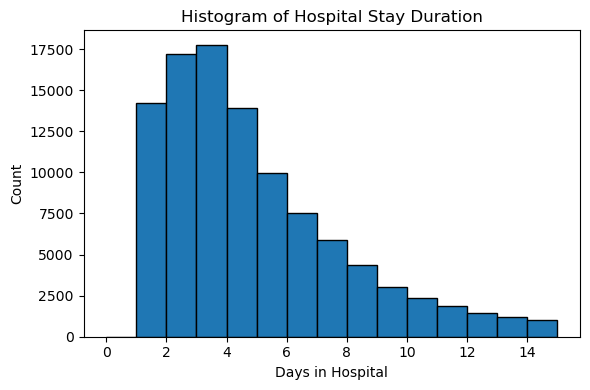

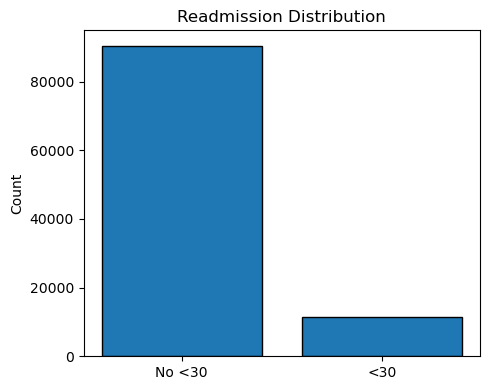

In [12]:
# 9) Basic EDA plots (histogram & outcome distribution)
if 'time_in_hospital' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['time_in_hospital'].dropna(), bins=range(0, int(df['time_in_hospital'].max())+2), edgecolor='black')
    plt.title("Histogram of Hospital Stay Duration")
    plt.xlabel("Days in Hospital"); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("results/fig_hist_time_in_hospital.png", dpi=150)
    plt.show()

plt.figure(figsize=(5,4))
vals, counts = np.unique(df['y'], return_counts=True)
plt.bar(['No <30','<30'], counts, edgecolor='black')
plt.title("Readmission Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("results/fig_readmission_distribution.png", dpi=150)
plt.show()


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import display

# 0) Ensure df is loaded
if 'df' not in globals():
    CSV_PATH = "diabetic_data.csv"
    if not os.path.exists(CSV_PATH):
        hits = sorted(glob.glob("*diabet*"))
        if hits:
            CSV_PATH = hits[0]
        else:
            raise FileNotFoundError("Put diabetic_data.csv next to the notebook or update CSV_PATH.")
    df = pd.read_csv(CSV_PATH, na_values=["?","NA","na","NaN","nan",""], low_memory=False)

# 1) Choose numeric columns
preferred = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
             'number_outpatient','number_emergency','number_inpatient']
num_cols = [c for c in preferred if c in df.columns]
if len(num_cols) < 2:
    # fallback: any numeric columns in the frame
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(num_cols) < 2:
    raise ValueError(f"Need at least 2 numeric columns; found {len(num_cols)}: {num_cols}")
print("Using numeric columns:", num_cols)

# 2) Numeric matrix: coerce -> median impute -> drop constants -> scale
Xnum = df[num_cols].apply(pd.to_numeric, errors='coerce')
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(Xnum), columns=num_cols, index=df.index)

var = X_imp.var(axis=0)
keep_cols = var[var > 0].index.tolist()
dropped = sorted(set(num_cols) - set(keep_cols))
if dropped:
    print("Dropped zero-variance columns:", dropped)
X_imp = X_imp[keep_cols]
if X_imp.shape[1] < 2:
    raise ValueError(f"Only {X_imp.shape[1]} usable numeric columns remain; kept: {list(X_imp.columns)}")

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns, index=X_imp.index)

# 3) K-Means (k=3)
km = KMeans(n_clusters=3, n_init=20, random_state=42)
clusters = km.fit_predict(X_scaled.values)
df['cluster'] = clusters
print("Cluster sizes:", pd.Series(clusters).value_counts().sort_index().to_dict())

# 4) Cluster profile (means & medians) and save
profile = df.groupby('cluster')[keep_cols].agg(['mean','median'])
display(profile)
os.makedirs("results", exist_ok=True)
profile.to_csv("results/cluster_profile.csv", index=True)
print("Saved: results/cluster_profile.csv")

# 5) PCA 2D plot and save
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled.values)
plt.figure(figsize=(6.5, 4.5))
plt.scatter(XY[:, 0], XY[:, 1], c=clusters, alpha=0.6)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("K-Means Clusters (k=3) – PCA Projection")
plt.tight_layout()
plt.savefig("results/fig_kmeans_pca_scatter.png", dpi=150)
plt.show()
print("Saved: results/fig_kmeans_pca_scatter.png")


Using numeric columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
